In [1]:
import os

from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
import seaborn as sns
import simdna
from simdna import synthetic
import statsmodels.api as sm
import torch
from tqdm.auto import tqdm

from utils import one_hot_decode
from in_silico_mutagenesis import compute_summary_statistics, generate_wt_mut_batches, write_results
from pyx.one_hot import one_hot
from tf_coop_model import CountsRegressor, IterablePandasDataset
from tf_coop_model import anscombe_transform, run_one_epoch, spearman_rho, pearson_r
from tf_coop_simulation import background_frequency
from tf_coop_simulation import simulate_counts, simulate_oracle_predictions

In [2]:
np.random.seed(42)

In [3]:
sequence_length = 100

test_data_fpath = '../dat/sim/test_labels.csv'
raw_simulation_data_fpath = '../dat/sim/test_sequences.simdata'

sequences_col = "sequences"
label_cols = ["labels_exp", "labels_out"]
batch_size = 1000
n_samples = 10

exposure_motif = "GATA_disc1"
outcome_motif = "TAL1_known1"

In [4]:
torch.set_grad_enabled(False)

# Load Test Data & Generate Predictions
Now we're going to load test data to get some basic metrics about how well our model performs.

In [5]:
test_df = pd.read_csv(test_data_fpath)
test_dataset = IterablePandasDataset(
    test_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=0
)

In [6]:
original_simulation_df = pd.read_csv(raw_simulation_data_fpath, sep="\t")

In [7]:
merged_data_df = original_simulation_df.merge(test_df, left_on="sequence", right_on="sequences")

In [8]:
both_motifs_df = merged_data_df[(merged_data_df['has_exposure'] == 1) & (merged_data_df['has_outcome'] == 1)]
exposure_motif_df = merged_data_df[merged_data_df['has_exposure'] == 1]
outcome_motif_df = merged_data_df[merged_data_df['has_outcome'] == 1]
neither_motif_df = merged_data_df[
    (merged_data_df['has_exposure'] == 0) & (merged_data_df['has_outcome'] == 0)
]

In [9]:
len(both_motifs_df), len(exposure_motif_df), len(outcome_motif_df), len(neither_motif_df)

(2488, 5029, 4990, 2469)

In [10]:
both_motifs_dataset = IterablePandasDataset(
    both_motifs_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
)
exposure_motif_dataset = IterablePandasDataset(
    exposure_motif_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
)

In [11]:
def mutate(seqs):
    preds = {}
    all_muts = []
    for seq in tqdm(seqs):
        muts = generate_wt_mut_batches(seq, seq.shape[0] * seq.shape[1]).squeeze()
        muts = muts.transpose(0, 1, 2)
        all_muts.append(muts)
    return np.array(all_muts)

In [12]:
both_motifs_sample_seqs = [x for x, y in both_motifs_dataset]

In [13]:
exposure_motif_sample_seqs = [x for x, y in exposure_motif_dataset]

In [14]:
sample_seqs = np.array([seq for seq, label in both_motifs_dataset])
sample_labels = np.array([label for _, label in both_motifs_dataset])
sample_muts = mutate(sample_seqs)

In [15]:
np.random.seed(42)

def simulate_adjusted_oracle_predictions(sequences, exposure_pwm, outcome_pwm, alpha=100, beta=100, perturb_by=1):
    q_exp, q_out = simulate_counts(sequences, exposure_pwm, outcome_pwm)
    q_exp = np.max((np.zeros_like(q_exp), q_exp-perturb_by), axis=0) # Different / impt line in this function.
    c_exp = alpha * q_exp
    c_out = beta * (q_exp * q_out)
    assert (np.isfinite(q_exp) & (q_exp >= 0)).all(), np.argwhere((np.isnan(q_exp) | (q_exp < 0)))
    c_exp_noisy = np.random.poisson(lam=c_exp, size=len(c_exp))
    c_out_noisy = np.random.poisson(lam=c_out, size=len(c_out))
    return c_exp_noisy, c_out_noisy

In [16]:
motifs = synthetic.LoadedEncodeMotifs(
    simdna.ENCODE_MOTIFS_PATH, pseudocountProb=0.001
)
exposure_pwm = motifs.loadedMotifs[exposure_motif].getRows()
outcome_pwm = motifs.loadedMotifs[outcome_motif].getRows()

In [17]:
# In-silico mut way of generating estimates
original_labels_scm = simulate_adjusted_oracle_predictions(
    [one_hot_decode(seq) for seq in sample_seqs],
    exposure_pwm,
    outcome_pwm,
    perturb_by=0
)
adjusted_labels_scm = simulate_adjusted_oracle_predictions(
    [one_hot_decode(seq) for seq in sample_seqs],
    exposure_pwm,
    outcome_pwm,
    perturb_by=.75
)
original_labels_scm = np.array(original_labels_scm)
adjusted_labels_scm = np.array(adjusted_labels_scm)
original_labels_scm, adjusted_labels_scm

(array([[ 99, 276, 182, ..., 124, 171, 113],
        [112, 269, 280, ..., 127, 213,  98]]),
 array([[ 26, 184, 104, ...,  40, 102,  22],
        [ 34, 184, 151, ...,  42, 124,  23]]))

In [18]:
original_labels_scm.shape, adjusted_labels_scm.shape

((2, 2488), (2, 2488))

In [19]:
scm_cis = ((adjusted_labels_scm[1, :] - original_labels_scm[1, :]) / 
           (adjusted_labels_scm[0, :] - original_labels_scm[0, :]))

In [20]:
original_labels_scm_anscombe = anscombe_transform(original_labels_scm)
adjusted_labels_scm_anscombe = anscombe_transform(adjusted_labels_scm)

In [21]:
scm_cis_anscombe = (
    (adjusted_labels_scm_anscombe[1, :] - original_labels_scm_anscombe[1, :]) / 
    (adjusted_labels_scm_anscombe[0, :] - original_labels_scm_anscombe[0, :])
)

In [22]:
adjusted_labels_ism = []
for i, muts in enumerate(tqdm(sample_muts)):
    adjusted_labels_ = simulate_oracle_predictions(
        [one_hot_decode(mut) for mut in muts],
        exposure_pwm,
        outcome_pwm
    )
    adjusted_labels_ism.append(adjusted_labels_)
adjusted_labels_ism = np.array(adjusted_labels_ism).reshape(len(sample_seqs), 4, 100, -1)
adjusted_labels_ism_anscombe = anscombe_transform(adjusted_labels_ism)

In [23]:
seq_idxs = np.array(sample_seqs).astype(np.bool)
adjusted_ref_labels_ism = adjusted_labels_ism_anscombe[seq_idxs].reshape(len(sample_seqs), 1, 100, -1)
adjusted_mut_labels_ism = adjusted_labels_ism_anscombe[~seq_idxs].reshape(len(sample_seqs), 3, 100, -1)
adjusted_diffs = adjusted_mut_labels_ism - adjusted_ref_labels_ism

In [24]:
ism_cis = []
for i in range(len(sample_seqs)):
    x = sm.add_constant(adjusted_diffs[i, :, :, 0].flatten(), prepend=False)
    y = adjusted_diffs[i, :, :, 1].flatten()
    ols_res = sm.OLS(y, x).fit()
    ism_cis.append(ols_res.params[0])

In [25]:
scm_cis_anscombe[:10], ism_cis[:10]

(array([0.98027049, 0.93044034, 1.3505625 , 1.23294924, 0.90717868,
        1.2456729 , 1.34931234, 0.92699493, 1.36125212, 0.78379906]),
 [0.15678271269398808,
  0.36124236384862174,
  0.6215828800536255,
  0.38171943074539383,
  0.20450904263993236,
  0.33195203366266773,
  0.19226532984577602,
  0.4344190452099441,
  0.29944113254667104,
  0.3322845993920476])

In [26]:
np.mean(scm_cis_anscombe), np.mean(ism_cis), np.std(scm_cis_anscombe), np.std(ism_cis)

(1.070174679544433,
 0.3280949891660079,
 0.2843773586394636,
 0.20310282831770451)

In [33]:
model_eff_sizes = pd.read_csv("../dat/sim/GATA_TAL1_effect_sizes_v2.csv")
model_eff_sizes.head()

,seq_num,X_pred_mean,X_pred_var,Y_pred_mean,Y_pred_var
0,1,-0.004477,0.016178,-0.002967,0.015600
1,1,-0.011389,0.108510,0.022476,0.100731
2,1,-0.010711,0.032885,-0.003526,0.028471
3,1,0.033556,0.032113,0.024267,0.024953
4,1,-0.044721,0.226065,-0.002928,0.102086


In [34]:
sample_model_eff_sizes = model_eff_sizes[model_eff_sizes.seq_num == 1]

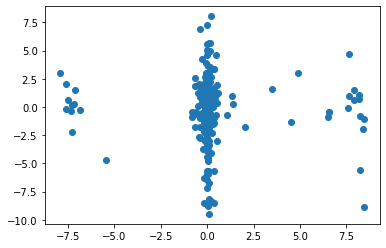

In [38]:
plt.scatter(sample_model_eff_sizes.X_pred_mean.values, adjusted_diffs[0][:, :, 0])

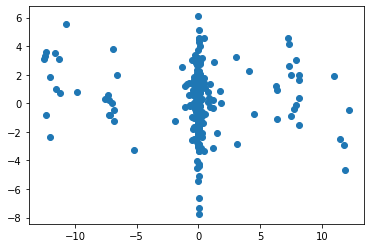

In [39]:
plt.scatter(sample_model_eff_sizes.Y_pred_mean.values, adjusted_diffs[0][:, :, 1])

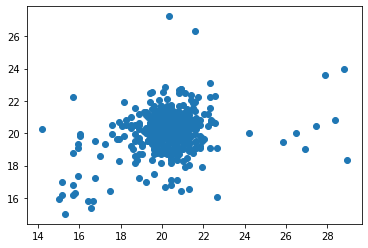

In [41]:
adjusted_labels_ism_anscombe.shape
plt.scatter(adjusted_labels_ism_anscombe[0, :, :, 0], adjusted_labels_ism_anscombe[0, :, :, 1])

In [43]:
model_means = np.load("GATA_TAL1_means_v3.npy")

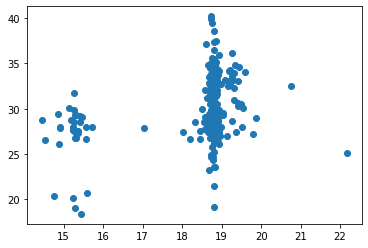

In [53]:
plt.scatter(model_means[2, :, :, 0], adjusted_labels_ism_anscombe[2, :, :, 0])

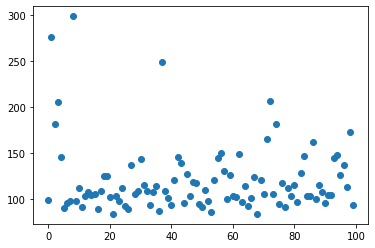

In [51]:
plt.scatter(np.arange(100), original_labels_scm[0, :100])